### Retinal Vessel Detection Using Autoencoders

In [1]:
%matplotlib inline
import os
import struct
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import random
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

### Data (DRIVE: https://www.isi.uu.nl/Research/Databases/DRIVE/)

In [2]:
Datapath = '/home/nbuser/nptel/DRIVE/training/images/'
Labelpath = '/home/nbuser/nptel/DRIVE/training/1st_manual/'

### Random Cropping from Images and corresponding Labels

In [3]:
# crop random bh x bw patches from images and also crop corresponding label
def img_transfer(img,imgLabel, bh, bw, no_of_patch):
    h = img.shape[0]
    w = img.shape[1]
    c = img.shape[2]
    ImgArr = np.empty((no_of_patch, bh*bw*3))
    LabelArr = np.empty((no_of_patch, bh*bw*1))

    for i in range(no_of_patch):
        ih = random.randint(0, h-bh)
        iw = random.randint(0, w-bw)
        iArrI = img[ih:ih+bh,iw:iw+bw,:]
        iArrL = imgLabel[ih:ih+bh,iw:iw+bw,:]       
        for ci in range(c):
            for bhi in range(bh):
                for bwi in range(bw):
                    ImgArr[i][ci*bh*bw + bhi*bw + bwi] = iArrI[bhi][bwi][ci]
                    if ci ==0:
                        LabelArr[i][ci*bh*bw + bhi*bw + bwi] = iArrL[bhi][bwi][ci]
        
    return ImgArr,LabelArr

In [4]:
# 10 x 10 patches
patchH = 10
patchW = 10
PatchperImage = 1000 # no of patches per image

In [5]:
TrainImages = torch.DoubleTensor(20*PatchperImage,3*patchH*patchW)
TrainLabels = torch.LongTensor(20*PatchperImage,patchH*patchW)

In [6]:
# Read each training image and crop random patches

t_no = 0
for img_no in range(20):
    imD = Image.open(Datapath + str(img_no+21) + '_training.tif')
    imD = np.array(imD)    
    
    imL = Image.open(Labelpath + str(img_no+21) + '_manual1.gif')
    imL = np.array(imL)
    imL = np.reshape(imL, (imL.shape[0],imL.shape[1],1))
    
    imD,imL = img_transfer(imD,imL, patchH, patchW, PatchperImage)
    imD = imD/255.0
    imL = imL/255.0
    for i in range(PatchperImage):
        TrainImages[t_no] = torch.from_numpy(imD[i])
        TrainLabels[t_no] = torch.from_numpy(imL[i])
        t_no = t_no + 1

In [7]:
print(TrainImages.size())
print(TrainLabels.size())

torch.Size([20000, 300])
torch.Size([20000, 100])


In [8]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

GPU is available!


### Define Autoencoder

In [9]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(300, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh())
        self.decoder = nn.Sequential(
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100,300),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


net = autoencoder()
print(net)

if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()
    
init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=300, bias=True)
    (3): Sigmoid()
  )
)


In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

### Train Autoencoder

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


At Iteration : 1 / 500  ;  Mean-Squared Error : 0.084230
At Iteration : 101 / 500  ;  Mean-Squared Error : 0.001992
At Iteration : 201 / 500  ;  Mean-Squared Error : 0.001124
At Iteration : 301 / 500  ;  Mean-Squared Error : 0.000757
At Iteration : 401 / 500  ;  Mean-Squared Error : 0.000563
Finished Training


Text(0,0.5,'Training loss')

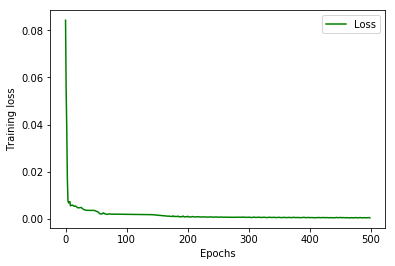

In [11]:
iterations = 500 #1000
BatchSize = 1000
trainLoss = []
for epoch in range(iterations):
    runningLoss = 0
    for i in range(20):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        if use_gpu:
            inputs = Variable(inputs).cuda()
        else:
            inputs = Variable(inputs)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss.data[0]
    trainLoss.append(runningLoss/(20000/BatchSize))
    if epoch%100 == 0:
        print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,runningLoss/
                                                                (TrainImages.size()[0]/BatchSize)))
print('Finished Training')


fig = plt.figure()        
plt.plot(range(epoch+1),trainLoss,'g-',label='Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Training loss')

### Encoder weight visualization

In [12]:
def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

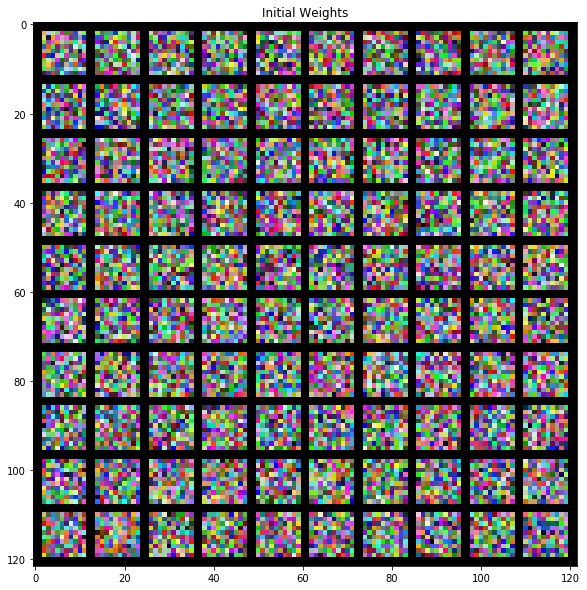

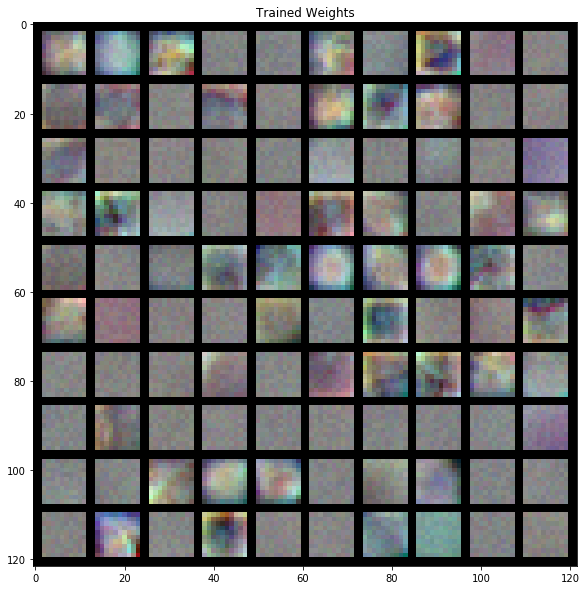

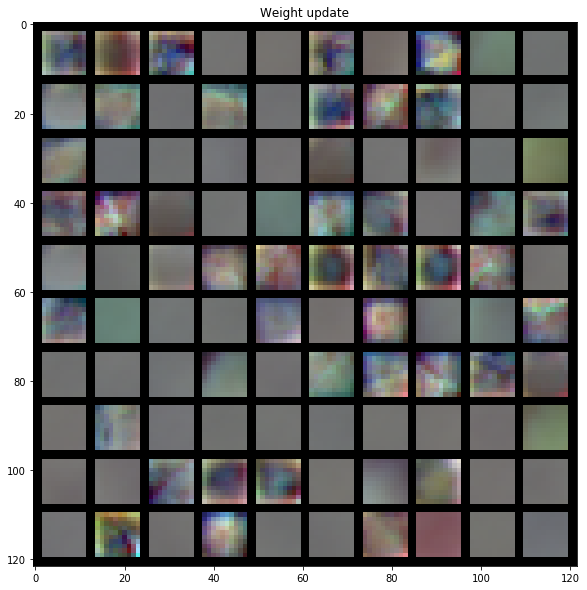

In [13]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)
d_weights = init_weights - trained_weights 

if use_gpu:
    init_weights = init_weights.view(100,3,10,10).cpu()
    trained_weights = trained_weights.view(100,3,10,10).cpu()
    d_weights = d_weights.view(100,3,10,10).cpu()
else:
    init_weights = init_weights.view(100,3,10,10)
    trained_weights = trained_weights.view(100,3,10,10)
    d_weights = d_weights.view(100,3,10,10)

imshow(torchvision.utils.make_grid(init_weights,nrow=10,normalize=True),'Initial Weights')
imshow(torchvision.utils.make_grid(trained_weights,nrow=10,normalize=True),'Trained Weights')
imshow(torchvision.utils.make_grid(d_weights,nrow=10,normalize=True), 'Weight update')

### Modifying the autoencoder for classification

In [14]:
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(patchH*patchW, patchH*patchW),nn.Sigmoid()))
print(net)
if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()

Sequential(
  (0): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Sigmoid()
  )
)


In [15]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


At Iteration: 1 / 500  ;  Training Loss: 0.512131 
At Iteration: 101 / 500  ;  Training Loss: 0.225335 
At Iteration: 201 / 500  ;  Training Loss: 0.193087 
At Iteration: 301 / 500  ;  Training Loss: 0.184054 
At Iteration: 401 / 500  ;  Training Loss: 0.168591 
Finished Training


Text(0,0.5,'Training loss')

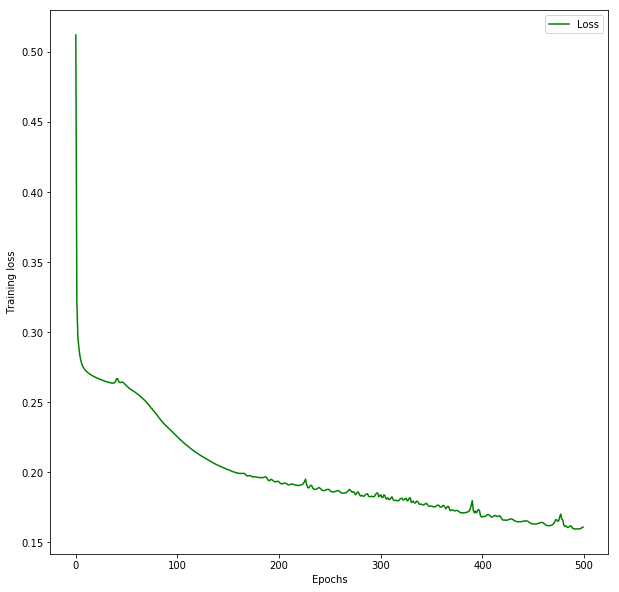

In [16]:
iterations = 500 #1000
BatchSize = 1000
trainLoss = []
for epoch in range(iterations): # loop over the dataset multiple times
    runningLoss = 0
    for i in range(20):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        labels = torch.index_select(TrainLabels,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad() # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        optimizer.step()
        runningLoss += loss.data[0]
    trainLoss.append(runningLoss/(20))
    if epoch%100 == 0:
        print('At Iteration: %d / %d  ;  Training Loss: %f '%(epoch + 1,iterations,runningLoss/(TrainImages.size()[0]/BatchSize)))
print('Finished Training')

fig = plt.figure()        
plt.plot(range(epoch+1),trainLoss,'g-',label='Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Training loss')

### Testing Performance

In [17]:
TestDatapath = '/home/nbuser/nptel/DRIVE/test/images/'  # Test Image Data Path
TestLabelpath = '/home/nbuser/nptel/DRIVE/test/1st_manual/'  # Test Image Manual Label

In [18]:
# Load Images and Convert Images into numpy array

imD = Image.open(TestDatapath + '01_test.tif')
imD = np.array(imD) 
imD = imD/255.0
    
imL = Image.open(TestLabelpath + '01_manual1.gif')
imL = np.array(imL)
imL = imL/255.0

In [19]:
x1 = int(imD.shape[0]/patchH)
x2 = int(imD.shape[1]/patchW)

In [20]:
# Break the image into 10 x 10 patches and push the patches into the network for vessel detection

TestArr = np.zeros(patchH*patchW*3)
imout = np.zeros((imD.shape[0],imD.shape[1]))

for i in range(x1):
    for j in range(x2):
        for l1 in range(3):
            for l2 in range(patchH):
                for l3 in range(patchW):
                    TestArr[l1*patchH*patchW + l2*patchW + l3] = imD[i*patchH +l2][j*patchW+l3][l1]
        TestTensor = torch.from_numpy(TestArr)
        out = net(Variable(TestTensor.double().cuda()))
        outArr = out.data.cpu().numpy()
        for l2 in range(patchH):
            for l3 in range(patchW):
                imout[i*patchH +l2][j*patchW+l3] = outArr[l2*patchW + l3]

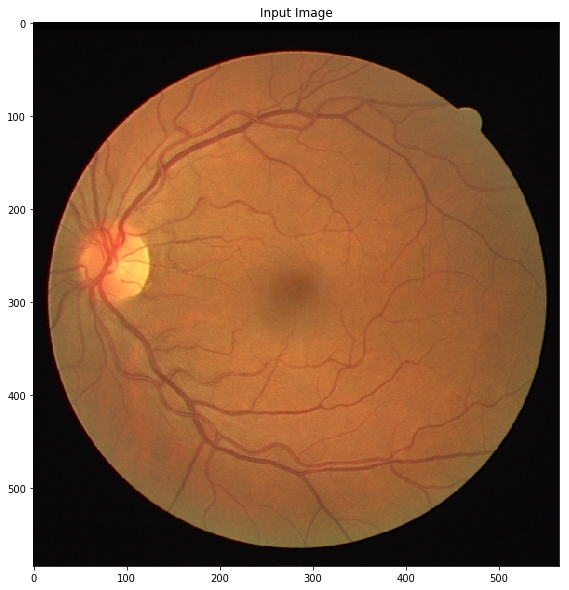

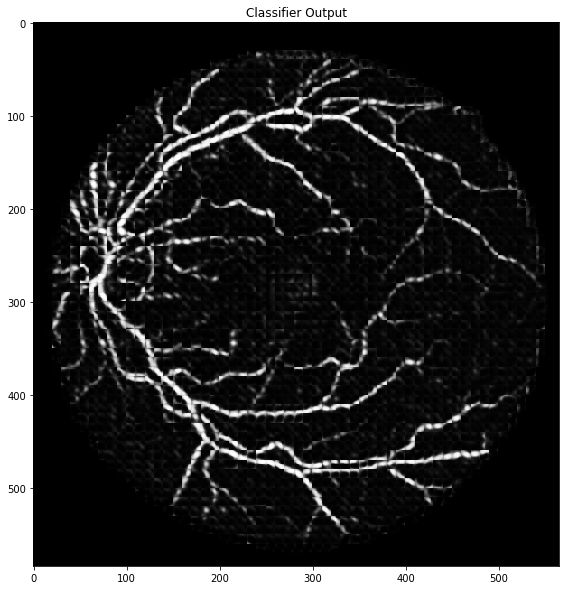

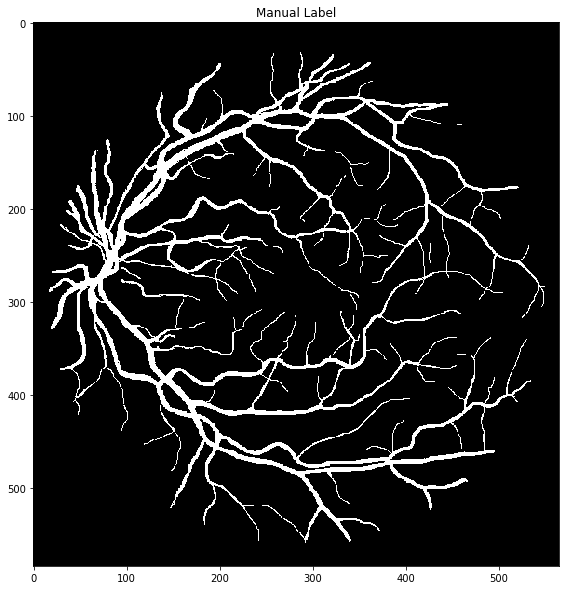

In [21]:
# Display results

plt.figure()
plt.title('Input Image')
plt.imshow(imD)

plt.figure()
plt.title('Classifier Output')
plt.imshow(imout, 'gray')

plt.figure()
plt.title('Manual Label')
plt.imshow(imL, 'gray')